In [117]:
from collections import defaultdict
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import yfinance as yf
from finta import TA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from tabulate import tabulate
from ta import add_all_ta_features

In [118]:
WINDOW = 8  # number of rows to look ahead to see what the price did
FETCH_INTERVAL = "60m"  # fetch data by interval (including intraday if period < 60 days)
# valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
# (optional, default is '1d')
INTERVAL = '1y'  # use "period" instead of start/end
# valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
# (optional, default is '1mo')
symbol = 'AAPL'  # Symbol of the desired stock
ROWS_TO_PREDICT = 128
# one day 16 rows of data

In [119]:
data = yf.download(  # or pdr.get_data_yahoo(...
        tickers = symbol,


        period = INTERVAL,

        interval = FETCH_INTERVAL,

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        # auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2020-05-11 14:30:00-04:00,78.807503,79.262497,78.802498,79.000000,79.000000,0
2020-05-11 15:30:00-04:00,78.997498,79.089996,78.747498,78.751251,78.751251,3250843
2020-05-11 16:00:00-04:00,78.752500,78.809950,78.642500,78.750000,78.750000,0
2020-05-11 17:00:00-04:00,78.727500,78.765000,78.690000,78.765000,78.765000,0
2020-05-11 18:00:00-04:00,78.762500,78.987500,78.737500,78.962500,78.962500,0
...,...,...,...,...,...,...
2021-05-11 11:30:00-04:00,125.074997,125.724998,124.720001,125.364998,125.364998,12362473
2021-05-11 12:30:00-04:00,125.364998,125.870003,124.730003,125.779900,125.779900,9225589
2021-05-11 13:30:00-04:00,125.776398,126.269997,125.510101,126.224998,126.224998,10086294


In [120]:
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
data.head(10)

In [121]:
important_columns = ['open', 'high', 'low','close']

def calculate_diffs(diff_number, col_name):
    new_col_name = f'{col_name}_{diff_number}'
    data[new_col_name] = data[col_name].diff(diff_number)

for name in important_columns:
    for i in range(1, 30):
        calculate_diffs(i, name)

In [122]:
for name in important_columns:
    for i in range(1, 30):
        calculate_diffs(i, name)

data.head(10)

,open,high,low,close,Adj Close,volume,open_1,open_2,open_3,open_4,...,close_20,close_21,close_22,close_23,close_24,close_25,close_26,close_27,close_28,close_29
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-05-11 14:30:00-04:00,78.807503,79.262497,78.802498,79.000000,79.000000,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-11 15:30:00-04:00,78.997498,79.089996,78.747498,78.751251,78.751251,3250843,0.189995,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-11 16:00:00-04:00,78.752500,78.809950,78.642500,78.750000,78.750000,0,-0.244998,-0.055003,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-11 17:00:00-04:00,78.727500,78.765000,78.690000,78.765000,78.765000,0,-0.025000,-0.269998,-0.080003,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-11 18:00:00-04:00,78.762500,78.987500,78.737500,78.962500,78.962500,0,0.035000,0.010000,-0.234998,-0.045003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-11 19:00:00-04:00,78.962500,78.962500,78.812500,78.817500,78.817500,0,0.200000,0.235000,0.210000,-0.034998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-12 04:00:00-04:00,78.802500,78.802500,78.560000,78.575000,78.575000,0,-0.160000,0.040000,0.075000,0.050000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-12 05:00:00-04:00,78.650000,78.675000,78.502500,78.502500,78.502500,0,-0.152500,-0.312500,-0.112500,-0.077500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-12 06:00:00-04:00,78.600000,78.822500,78.535000,78.822500,78.822500,0,-0.050000,-0.202500,-0.362500,-0.162500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
data = data.dropna()

<AxesSubplot:xlabel='Datetime'>

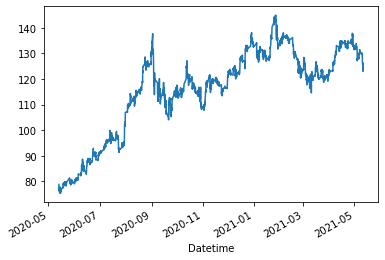

In [124]:
data['close'].plot()

In [125]:
data['close_pct'] = data['close'].pct_change()
data.head()

<ipython-input-125-b350896b28a2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close_pct'] = data['close'].pct_change()


,open,high,low,close,Adj Close,volume,open_1,open_2,open_3,open_4,...,close_21,close_22,close_23,close_24,close_25,close_26,close_27,close_28,close_29,close_pct
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-05-13 09:30:00-04:00,78.037498,78.834976,77.642502,78.782501,78.782501,10815742,-0.325002,-0.080002,-0.167502,0.039998,...,-0.039999,0.280001,0.207501,-0.034999,-0.179999,0.017501,0.032501,0.031250,-0.217499,NaN
2020-05-13 10:30:00-04:00,78.787498,78.987503,77.767502,77.984978,77.984978,6802303,0.750000,0.424998,0.669998,0.582498,...,-1.292522,-0.837522,-0.517522,-0.590022,-0.832522,-0.977522,-0.780022,-0.765022,-0.766273,-0.010123
2020-05-13 11:30:00-04:00,77.985001,78.125000,75.802498,76.611198,76.611198,9925061,-0.802498,-0.052498,-0.377499,-0.132499,...,-2.788802,-2.666302,-2.211302,-1.891302,-1.963802,-2.206302,-2.351302,-2.153802,-2.138802,-0.017616
2020-05-13 12:30:00-04:00,76.617500,77.040001,76.137497,76.374977,76.374977,5824206,-1.367500,-2.169998,-1.419998,-1.745000,...,-3.100023,-3.025023,-2.902523,-2.447523,-2.127523,-2.200023,-2.442523,-2.587523,-2.390023,-0.003083
2020-05-13 13:30:00-04:00,76.367500,76.724998,75.955002,76.417747,76.417747,3984653,-0.250000,-1.617500,-2.419998,-1.669998,...,-2.874756,-3.057253,-2.982253,-2.859753,-2.404753,-2.084753,-2.157253,-2.399753,-2.544753,0.000560


In [126]:
data.describe()




,open,high,low,close,Adj Close,volume,open_1,open_2,open_3,open_4,...,close_21,close_22,close_23,close_24,close_25,close_26,close_27,close_28,close_29,close_pct
count,4160.000000,4160.000000,4160.000000,4160.000000,4160.000000,4.160000e+03,4160.000000,4160.000000,4160.000000,4160.000000,...,4160.000000,4160.000000,4160.000000,4160.000000,4160.000000,4160.000000,4160.000000,4160.000000,4160.000000,4159.000000
mean,115.506279,116.052143,114.863741,115.504484,115.504484,5.085870e+06,0.011394,0.022957,0.034392,0.045779,...,0.237402,0.249397,0.261353,0.273269,0.285497,0.297769,0.310091,0.322423,0.334634,0.000127
std,16.788223,17.633923,16.741629,16.776054,16.776054,8.597976e+06,0.621785,0.865458,1.051043,1.218583,...,2.858015,2.920499,2.978768,3.036069,3.097343,3.156758,3.220507,3.278671,3.334515,0.005420
min,75.087502,75.537500,58.360000,75.300000,75.300000,0.000000e+00,-6.983299,-6.618202,-7.669999,-7.479998,...,-15.039297,-16.059297,-16.830002,-17.679297,-17.819297,-18.480000,-20.380000,-20.490000,-20.090000,-0.051319
25%,109.365625,109.752501,108.664999,109.330940,109.330940,0.000000e+00,-0.230000,-0.335626,-0.439999,-0.530754,...,-1.302256,-1.341255,-1.380880,-1.385001,-1.399999,-1.393648,-1.438676,-1.430000,-1.470576,-0.001888
50%,119.589998,120.070000,118.798567,119.571949,119.571949,0.000000e+00,0.010000,0.032500,0.059998,0.095000,...,0.253737,0.230001,0.253749,0.262502,0.270000,0.300000,0.303543,0.321502,0.322155,0.000100
75%,128.306245,128.740001,127.632572,128.302502,128.302502,8.338372e+06,0.270002,0.415437,0.557137,0.660000,...,1.780000,1.840000,1.818126,1.845628,1.862185,1.893129,1.946249,1.990003,1.980000,0.002273
max,144.900000,438.440000,144.590000,144.910000,144.910000,9.845401e+07,5.901306,6.266403,6.077496,8.195000,...,11.137500,11.580002,12.095001,12.350003,12.625003,12.825000,12.910000,13.607475,13.789978,0.051457


In [127]:
data

,open,high,low,close,Adj Close,volume,open_1,open_2,open_3,open_4,...,close_21,close_22,close_23,close_24,close_25,close_26,close_27,close_28,close_29,close_pct
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-05-13 09:30:00-04:00,78.037498,78.834976,77.642502,78.782501,78.782501,10815742,-0.325002,-0.080002,-0.167502,0.039998,...,-0.039999,0.280001,0.207501,-0.034999,-0.179999,0.017501,0.032501,0.031250,-0.217499,NaN
2020-05-13 10:30:00-04:00,78.787498,78.987503,77.767502,77.984978,77.984978,6802303,0.750000,0.424998,0.669998,0.582498,...,-1.292522,-0.837522,-0.517522,-0.590022,-0.832522,-0.977522,-0.780022,-0.765022,-0.766273,-0.010123
2020-05-13 11:30:00-04:00,77.985001,78.125000,75.802498,76.611198,76.611198,9925061,-0.802498,-0.052498,-0.377499,-0.132499,...,-2.788802,-2.666302,-2.211302,-1.891302,-1.963802,-2.206302,-2.351302,-2.153802,-2.138802,-0.017616
2020-05-13 12:30:00-04:00,76.617500,77.040001,76.137497,76.374977,76.374977,5824206,-1.367500,-2.169998,-1.419998,-1.745000,...,-3.100023,-3.025023,-2.902523,-2.447523,-2.127523,-2.200023,-2.442523,-2.587523,-2.390023,-0.003083
2020-05-13 13:30:00-04:00,76.367500,76.724998,75.955002,76.417747,76.417747,3984653,-0.250000,-1.617500,-2.419998,-1.669998,...,-2.874756,-3.057253,-2.982253,-2.859753,-2.404753,-2.084753,-2.157253,-2.399753,-2.544753,0.000560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-11 11:30:00-04:00,125.074997,125.724998,124.720001,125.364998,125.364998,12362473,1.625000,1.574997,2.064997,1.364997,...,-4.455002,-4.645002,-4.685002,-4.435002,-4.605002,-5.125002,-4.855002,-4.850002,-4.945002,0.002359
2021-05-11 12:30:00-04:00,125.364998,125.870003,124.730003,125.779900,125.779900,9225589,0.290001,1.915001,1.864998,2.354998,...,-4.050100,-4.040100,-4.230100,-4.270100,-4.020100,-4.190100,-4.710100,-4.440100,-4.435100,0.003310
2021-05-11 13:30:00-04:00,125.776398,126.269997,125.510101,126.224998,126.224998,10086294,0.411400,0.701401,2.326401,2.276398,...,-2.159996,-3.605002,-3.595002,-3.785002,-3.825002,-3.575002,-3.745002,-4.265002,-3.995002,0.003539


In [128]:
data.columns

Index(['open', 'high', 'low', 'close', 'Adj Close', 'volume', 'open_1',
       'open_2', 'open_3', 'open_4',
       ...
       'close_21', 'close_22', 'close_23', 'close_24', 'close_25', 'close_26',
       'close_27', 'close_28', 'close_29', 'close_pct'],
      dtype='object', length=123)

In [129]:
def create_class_column(row, lowest_threshold, higher_threshold):
    if row['close_shift'] - row['close'] > higher_threshold:
        return 1
    if row['close_shift'] - row['close'] < lowest_threshold:
        return -1
    else:
        return 0

In [130]:
data['close_shift'] = data.shift(-WINDOW)['close']
data

<ipython-input-130-f6ee39db52be>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close_shift'] = data.shift(-WINDOW)['close']


,open,high,low,close,Adj Close,volume,open_1,open_2,open_3,open_4,...,close_22,close_23,close_24,close_25,close_26,close_27,close_28,close_29,close_pct,close_shift
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-05-13 09:30:00-04:00,78.037498,78.834976,77.642502,78.782501,78.782501,10815742,-0.325002,-0.080002,-0.167502,0.039998,...,0.280001,0.207501,-0.034999,-0.179999,0.017501,0.032501,0.031250,-0.217499,NaN,77.1675
2020-05-13 10:30:00-04:00,78.787498,78.987503,77.767502,77.984978,77.984978,6802303,0.750000,0.424998,0.669998,0.582498,...,-0.837522,-0.517522,-0.590022,-0.832522,-0.977522,-0.780022,-0.765022,-0.766273,-0.010123,77.1375
2020-05-13 11:30:00-04:00,77.985001,78.125000,75.802498,76.611198,76.611198,9925061,-0.802498,-0.052498,-0.377499,-0.132499,...,-2.666302,-2.211302,-1.891302,-1.963802,-2.206302,-2.351302,-2.153802,-2.138802,-0.017616,77.2875
2020-05-13 12:30:00-04:00,76.617500,77.040001,76.137497,76.374977,76.374977,5824206,-1.367500,-2.169998,-1.419998,-1.745000,...,-3.025023,-2.902523,-2.447523,-2.127523,-2.200023,-2.442523,-2.587523,-2.390023,-0.003083,76.9200
2020-05-13 13:30:00-04:00,76.367500,76.724998,75.955002,76.417747,76.417747,3984653,-0.250000,-1.617500,-2.419998,-1.669998,...,-3.057253,-2.982253,-2.859753,-2.404753,-2.084753,-2.157253,-2.399753,-2.544753,0.000560,77.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-11 11:30:00-04:00,125.074997,125.724998,124.720001,125.364998,125.364998,12362473,1.625000,1.574997,2.064997,1.364997,...,-4.645002,-4.685002,-4.435002,-4.605002,-5.125002,-4.855002,-4.850002,-4.945002,0.002359,NaN
2021-05-11 12:30:00-04:00,125.364998,125.870003,124.730003,125.779900,125.779900,9225589,0.290001,1.915001,1.864998,2.354998,...,-4.040100,-4.230100,-4.270100,-4.020100,-4.190100,-4.710100,-4.440100,-4.435100,0.003310,NaN
2021-05-11 13:30:00-04:00,125.776398,126.269997,125.510101,126.224998,126.224998,10086294,0.411400,0.701401,2.326401,2.276398,...,-3.605002,-3.595002,-3.785002,-3.825002,-3.575002,-3.745002,-4.265002,-3.995002,0.003539,NaN


In [131]:
higher_threshold = 1.5
lowest_threshold = -1.5
last_values_higher = []
last_values_lower = []
data['class_column'] = data.apply((lambda x: create_class_column(x, lowest_threshold, higher_threshold)), axis=1)
while True:
    print(data['class_column'].value_counts())
    class_counts = data['class_column'].value_counts()
    if abs(class_counts[0] - class_counts[1]) < 15 and abs(class_counts[0] - class_counts[-1]) < 15:
        break

    if len(last_values_higher) == 3:
        last_values_higher.pop(0)
    if len(last_values_lower) == 3:
        last_values_lower.pop(0)

    last_values_higher.append(higher_threshold)
    last_values_lower.append(lowest_threshold)
    if class_counts[0] > class_counts[1]:
        higher_threshold -= 0.01
    if class_counts[0] > class_counts[-1]:
        lowest_threshold += 0.01
    if class_counts[0] < class_counts[1]:
        higher_threshold += 0.01
    if class_counts[0] < class_counts[-1]:
        lowest_threshold -= 0.01

    if higher_threshold in last_values_higher and lowest_threshold in last_values_lower:
        break
    print(higher_threshold, lowest_threshold)
    data['class_column'] = data.apply((lambda x: create_class_column(x, lowest_threshold, higher_threshold)), axis=1)

data

<ipython-input-131-1209792257c8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['class_column'] = data.apply((lambda x: create_class_column(x, lowest_threshold, higher_threshold)), axis=1)
<ipython-input-131-1209792257c8>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['class_column'] = data.apply((lambda x: create_class_column(x, lowest_threshold, higher_threshold)), axis=1)


 0    2920
 1     684
-1     556
Name: class_column, dtype: int64
1.49 -1.49
 0    2902
 1     695
-1     563
Name: class_column, dtype: int64
1.48 -1.48
 0    2893
 1     699
-1     568
Name: class_column, dtype: int64
1.47 -1.47
 0    2880
 1     707
-1     573
Name: class_column, dtype: int64
1.46 -1.46
 0    2869
 1     714
-1     577
Name: class_column, dtype: int64
1.45 -1.45
 0    2854
 1     725
-1     581
Name: class_column, dtype: int64
1.44 -1.44
 0    2839
 1     733
-1     588
Name: class_column, dtype: int64
1.43 -1.43
 0    2826
 1     737
-1     597
Name: class_column, dtype: int64
1.42 -1.42
 0    2819
 1     741
-1     600
Name: class_column, dtype: int64
1.41 -1.41
 0    2813
 1     743
-1     604
Name: class_column, dtype: int64
1.4 -1.4
 0    2799
 1     749
-1     612
Name: class_column, dtype: int64
1.39 -1.39
 0    2789
 1     753
-1     618
Name: class_column, dtype: int64
1.38 -1.38
 0    2776
 1     762
-1     622
Name: class_column, dtype: int64
1.3699999999

,open,high,low,close,Adj Close,volume,open_1,open_2,open_3,open_4,...,close_23,close_24,close_25,close_26,close_27,close_28,close_29,close_pct,close_shift,class_column
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-05-13 09:30:00-04:00,78.037498,78.834976,77.642502,78.782501,78.782501,10815742,-0.325002,-0.080002,-0.167502,0.039998,...,0.207501,-0.034999,-0.179999,0.017501,0.032501,0.031250,-0.217499,NaN,77.1675,-1
2020-05-13 10:30:00-04:00,78.787498,78.987503,77.767502,77.984978,77.984978,6802303,0.750000,0.424998,0.669998,0.582498,...,-0.517522,-0.590022,-0.832522,-0.977522,-0.780022,-0.765022,-0.766273,-0.010123,77.1375,-1
2020-05-13 11:30:00-04:00,77.985001,78.125000,75.802498,76.611198,76.611198,9925061,-0.802498,-0.052498,-0.377499,-0.132499,...,-2.211302,-1.891302,-1.963802,-2.206302,-2.351302,-2.153802,-2.138802,-0.017616,77.2875,0
2020-05-13 12:30:00-04:00,76.617500,77.040001,76.137497,76.374977,76.374977,5824206,-1.367500,-2.169998,-1.419998,-1.745000,...,-2.902523,-2.447523,-2.127523,-2.200023,-2.442523,-2.587523,-2.390023,-0.003083,76.9200,0
2020-05-13 13:30:00-04:00,76.367500,76.724998,75.955002,76.417747,76.417747,3984653,-0.250000,-1.617500,-2.419998,-1.669998,...,-2.982253,-2.859753,-2.404753,-2.084753,-2.157253,-2.399753,-2.544753,0.000560,77.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-11 11:30:00-04:00,125.074997,125.724998,124.720001,125.364998,125.364998,12362473,1.625000,1.574997,2.064997,1.364997,...,-4.685002,-4.435002,-4.605002,-5.125002,-4.855002,-4.850002,-4.945002,0.002359,NaN,0
2021-05-11 12:30:00-04:00,125.364998,125.870003,124.730003,125.779900,125.779900,9225589,0.290001,1.915001,1.864998,2.354998,...,-4.230100,-4.270100,-4.020100,-4.190100,-4.710100,-4.440100,-4.435100,0.003310,NaN,0
2021-05-11 13:30:00-04:00,125.776398,126.269997,125.510101,126.224998,126.224998,10086294,0.411400,0.701401,2.326401,2.276398,...,-3.595002,-3.785002,-3.825002,-3.575002,-3.745002,-4.265002,-3.995002,0.003539,NaN,0


In [132]:
# Class divide
data['class_column'].value_counts()

-1    1393
 0    1385
 1    1382
Name: class_column, dtype: int64

In [133]:
filename_to_export = f'../data/preprocess_new/{symbol}_{INTERVAL}_{WINDOW}_only_diff_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}_full.csv'
data.to_csv(filename_to_export, index=True)
print(filename_to_export)

../data/preprocess_new/AAPL_1y_8_only_diff_11_05_2021 20_40_14_full.csv
